## TRANSFORMER: FIRST DRAFT

### IMPORTS

In [1]:
import sys
import os
from pathlib import Path

current_path = Path(os.getcwd())

project_root = current_path.parent.parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Working in: {current_path}")
print(f"Root of the project: {project_root}")

try:
    import nuimages 
    import nuscenes
except ImportError as e:
    print(f"Error: {e}")

Working in: /root/nuscenes-devkit/python-sdk/main/notebooks
Root of the project: /root/nuscenes-devkit/python-sdk


In [2]:
import argparse
import pickle
from nuscenes import NuScenes
import os
import json
from nuscenes.map_expansion.map_api import NuScenesMap

from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import transform_matrix
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
import torch
import numpy as np
from pyquaternion import Quaternion
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle
from nuscenes.eval.prediction.data_classes import Prediction

from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.data_classes import Prediction
from nuscenes.eval.prediction.metrics import MinADEK, MinFDEK, RowMean
from nuscenes.prediction.models.backbone import ResNetBackbone

from matplotlib import pyplot as plt

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.models.physics import ConstantVelocityHeading, PhysicsOracle

from nuscenes.map_expansion import arcline_path_utils
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet

from torch.utils.data import Dataset, DataLoader
from nuscenes.prediction.models.mtp import MTPLoss

import torch.nn as nn

MINI wayformer a partir d'embeddings

Primer s'ha hagut de fer els embeddings i concatenarlos. 

In [3]:
# shapes de entrada al Transformer (que prepararás después)
# bev_emb:      (batch_size, 1, D)
# agent_embs:   (batch_size, N_agents, D)
# lane_embs:    (batch_size, N_lanes, D)

# y luego los concatenas:
# tokens = torch.cat([bev_emb, agent_embs, lane_embs], dim=1)  # (B, T, D)


### agent embedding:

CADA AGENT TÉ AIXÒ: posición (x, y), velocidad, aceleración, heading (ángulo), tamaño (width, length),clase (car, pedestrian, bicycle…), historia pasada (opcional), estado actual (si está quieto o no, etc.)

amb una dimensionalidad podriem tenir un feature vector així: [x, y, vx, vy, ax, ay, heading_sin, heading_cos, width, length]


In [4]:
def extract_agent_features(helper, instance_token, sample_token):
    ann = helper.get_sample_annotation(instance_token, sample_token)

    # Position
    x, y, _ = ann["translation"]

    # Velocity
    vx, vy = helper.get_velocity_for_agent(instance_token, sample_token)

    # Acceleration
    ax, ay = helper.get_acceleration_for_agent(instance_token, sample_token)

    # Heading (convert quaternion → sin/cos)
    quat = ann["rotation"]  # [qw, qx, qy, qz]
    yaw = Quaternion(quat).yaw_pitch_roll[0]
    sin_yaw = np.sin(yaw)
    cos_yaw = np.cos(yaw)

    # Size
    width, length, _ = ann["size"]

    # Feature vector
    features = np.array([x, y, vx, vy, ax, ay, sin_yaw, cos_yaw, width, length], dtype=np.float32)

    return features  # shape (10,)


## PASSAR TOTS ELS AGENTS PER UN MLP PER TENIR AGENT EMBEDDING DE agent embedding (B, N_agents, D)
class AgentEncoder(nn.Module):
    def __init__(self, in_dim=10, hidden_dim=128, out_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, agent_features):
        """
        agent_features: (B, N_agents, 10)
        returns: (B, N_agents, out_dim)
        """
        return self.mlp(agent_features)

MAX_AGENTS = 12  # como Waymo, puedes escoger 12–16

def build_agent_embeddings(helper, sample_token, agent_encoder, device):
    anns = helper.get_annotations_for_sample(sample_token)

    features = []

    for ann in anns:
        instance_token = ann["instance_token"]
        f = extract_agent_features(helper, instance_token, sample_token)
        features.append(f)

        if len(features) == MAX_AGENTS:
            break

    # Padding
    while len(features) < MAX_AGENTS:
        features.append(np.zeros(10, dtype=np.float32))

    features = torch.tensor(features, device=device)  # (MAX_AGENTS, 10)
    features = features.unsqueeze(0)  # (1, MAX_AGENTS, 10)

    # Agent Encoder
    with torch.no_grad():  # or leave gradients if end-to-end
        agent_emb = agent_encoder(features)  # (1, MAX_AGENTS, d_model)

    return agent_emb  # shape (1, N_agents, d_model)


### Lane embeddings

L'objectiu és donat un sample_token lane_emb: (1, N_lanes, d_model). Cada lane a nuscenes es un polyline ([(x1, y1), (x2, y2), ..., (xk, yk)])
cADA LANE TIENE Type,conexiones, direccion del trafico y curbatura

Pero la mínima base funcional para un Transformer es:

✔ samplear la polilínea
✔ convertir cada punto a un feature
✔ agregar todos los puntos para crear un embedding por lane

Obtenim les polylines més properes al agent

In [5]:
def get_relevant_lanes(helper, agent_x, agent_y, max_lanes=8):
    """
    Returns up to max_lanes lane IDs near the agent.
    """
    lane_ids = helper.map_api.get_lane_ids_in_xy(agent_x, agent_y)

    # If too many lanes, keep closest N
    if len(lane_ids) > max_lanes:
        lane_ids = lane_ids[:max_lanes]

    return lane_ids


Treiem la polilínea de cada agent

In [6]:
def get_lane_polyline(helper, lane_id):
    # returns Nx2 array with (x, y)
    poly = helper.map_api.get_lane_centerline(lane_id)[:, :2]
    return poly  # shape (K, 2)


Convertim cada polilínea en un conjunt de features (com es fa a implementacions com LaneGCN y Vectornet)
dx, dy                 → dirección del segmento
length                 → distancia
norm direction         → dx / length, dy / length
curvature              → change of angle (si queremos)


In [7]:
import numpy as np

def polyline_to_features(poly):
    """
    poly: (K,2)
    returns features for each segment: (K-1, 5)
    """
    segments = []
    for i in range(len(poly) - 1):
        x1, y1 = poly[i]
        x2, y2 = poly[i+1]

        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx*dx + dy*dy) + 1e-6
        nx = dx / length
        ny = dy / length

        # Feature per segment
        feat = [dx, dy, length, nx, ny]
        segments.append(feat)

    return np.array(segments, dtype=np.float32)  # (K-1, 5)


Ara MLP com abans per fer el lane encoder. 

In [8]:
class LaneSegmentEncoder(nn.Module):
    def __init__(self, in_dim=5, hidden_dim=128, out_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, seg_features):
        """
        seg_features: (num_segments, in_dim)
        returns: (num_segments, out_dim)
        """
        return self.mlp(seg_features)


In [9]:
def aggregate_lane_embedding(segment_embs):
    """
    segment_embs: (num_segments, d_model)
    returns a single lane embedding: (d_model,)
    """
    return segment_embs.mean(dim=0)  # or max(dim=0)[0]


In [10]:
def build_lane_embedding(helper, lane_id, lane_encoder, device):
    # 1. Polyline
    poly = get_lane_polyline(helper, lane_id)  # (K,2)

    seg_feats = polyline_to_features(poly)     # (K-1, 5)
    seg_feats = torch.tensor(seg_feats, device=device)

    # 2. Encode each segment
    seg_embs = lane_encoder(seg_feats)         # (K-1, d_model)

    # 3. Aggregate segment embeddings
    lane_emb = seg_embs.mean(dim=0)            # (d_model,)

    return lane_emb


Hacemos embedings para todos los lanes

In [11]:
MAX_LANES = 8

def build_lane_embeddings(helper, agent_x, agent_y, lane_encoder, device):
    lane_ids = get_relevant_lanes(helper, agent_x, agent_y, max_lanes=MAX_LANES)

    lane_embs = []
    for lane_id in lane_ids:
        emb = build_lane_embedding(helper, lane_id, lane_encoder, device)
        lane_embs.append(emb)

    # Padding
    while len(lane_embs) < MAX_LANES:
        lane_embs.append(torch.zeros(lane_embs[0].shape, device=device))

    lane_embs = torch.stack(lane_embs, dim=0)  # (MAX_LANES, d_model)
    lane_embs = lane_embs.unsqueeze(0)         # (1, MAX_LANES, d_model)

    return lane_embs


El resultado tendria que ser un sistema on el lane_emb :(1,N_lanes, d_model)

### Bird Eye View embedding

Aquest embedding hauria de ser un tensor que resumeixi tota la escena. bev_emb: (1, 1, d_model)

La imatge rasterizada en vista cenital ja està implementada a nuscnees: 

In [12]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/root/nuscenes-devkit/data/sets/nuscenes'

nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.252 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [13]:
helper = PredictHelper(nuscenes)
static_layer_rasterizer = StaticLayerRasterizer(helper)
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())
# img = mtp_input_representation.make_input_representation(instance_token, sample_token)


La imatge que produeix el multicanal d'unes dimensions com: (3, 224, 224)    o (3, 500, 500)  según configuración
    

Això se li pasa a una resnet (cnn) treiem un embedding i el reduim a d_model i serà el primer token del transformer

In [14]:
import torchvision.models as models
import torch.nn as nn
import torch

"""

"""
class BEVBackbone(nn.Module):
    def __init__(self, out_dim=128, arch="resnet18"):
        super().__init__()

        if arch == "resnet18":
            base = models.resnet18(weights=None)
            feat_dim = 512
        elif arch == "resnet50":
            base = models.resnet50(weights=None)
            feat_dim = 2048
        else:
            raise ValueError("Unsupported backbone")

        # Remove final FC layer, keep convolutional trunk
        self.cnn = nn.Sequential(*list(base.children())[:-1])  # output: (B, feat_dim, 1, 1)

        # MLP to project onto transformer dimension
        self.proj = nn.Linear(feat_dim, out_dim)

    def forward(self, bev_img):
        """
        bev_img: (B, C, H, W)
        returns: (B, out_dim)
        """
        x = self.cnn(bev_img)         # (B, feat_dim, 1, 1)
        x = x.view(x.size(0), -1)     # (B, feat_dim)
        x = self.proj(x)              # (B, out_dim)
        return x


In [15]:
class BEVEncoder(nn.Module):
    def __init__(self, input_representation, d_model=128, arch="resnet18", device="cpu"):
        super().__init__()
        self.input_representation = input_representation
        self.device = device

        # CNN backbone to extract features
        self.backbone = BEVBackbone(out_dim=d_model, arch=arch).to(device)

    def forward(self, instance_token, sample_token):
        """
        Returns:
            bev_token: (1, 1, d_model)
        """

        # 1) Rasterize nuScenes BEV image
        img = self.input_representation.make_input_representation(
            instance_token, sample_token
        )   # numpy array (H, W, C)

        # 2) Convert → torch tensor
        bev_img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C,H,W)
        bev_img = bev_img.unsqueeze(0).to(self.device)                    # (1,C,H,W)

        # 3) Normalize (IMPORTANT — like ImageNet)
        bev_img = (bev_img - bev_img.mean()) / (bev_img.std() + 1e-6)

        # 4) Extract embedding using CNN backbone
        bev_emb = self.backbone(bev_img)   # (1, d_model)

        # 5) Convert to a single transformer token → (1,1,d_model)
        bev_token = bev_emb.unsqueeze(1)

        return bev_token


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bev_encoder = BEVEncoder(
    input_representation=mtp_input_representation,
    d_model=128,
    arch="resnet18",
    device=device
)

# OBTENER TOKEN PARA UN SAMPLE
# bev_token = bev_encoder(instance_token, sample_token)
# print(bev_token.shape)

# la sortida hauria de ser: torch.Size([1, 1, 128])



In [17]:
def build_bev_embedding(self, instance_token, sample_token):
    
    # 1. Rasterize BEV image (you already do this)
    img = self.input_representation.make_input_representation(
        instance_token, sample_token
    )  # numpy array (H, W, C)

    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)
    img = img.unsqueeze(0).to(self.device)  # (1, C, H, W)

    # 2. Backbone CNN → embedding
    bev_emb = self.bev_backbone(img)        # (1, d_model)

    # 3. Convert to transformer token
    bev_token = bev_emb.unsqueeze(1)        # (1, 1, d_model)

    return bev_token


### Transformer

Després només fa falta el model transformer i el head de predicció de trajectories. 

In [18]:
import math
import torch
from torch import nn
from torch.nn import functional as F

# (PositionalEncoding se mantiene igual, no hace falta cambiarlo)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 256):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0)) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x


class TrajectoryTransformer(nn.Module):
    def __init__(
        self,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 256,
        dropout: float = 0.1,
        num_modes: int = 6,
        num_steps: int = 12,
        use_mode_head: bool = True,
    ):
        super().__init__()
        self.d_model = d_model
        self.num_modes = num_modes
        self.num_steps = num_steps
        
        # Encoder
        self.pos_encoder = PositionalEncoding(d_model=d_model, max_len=256)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.scene_pool = "first" 
        
        # --- HEADS ---
        # Predice DELTAS (velocidades dx, dy) en lugar de posiciones absolutas
        self.traj_head = nn.Linear(d_model, num_modes * num_steps * 2)

        if use_mode_head and num_modes > 1:
            self.mode_head = nn.Linear(d_model, num_modes)
        else:
            self.mode_head = None

    def _pool_scene_token(self, encoded_tokens):
        if self.scene_pool == "first":
            return encoded_tokens[:, 0, :]
        elif self.scene_pool == "mean":
            return encoded_tokens.mean(dim=1)
        return encoded_tokens[:, 0, :]

    def forward(
        self,
        token_embeddings: torch.Tensor,
        src_key_padding_mask: torch.Tensor | None = None,
    ):
        # 1) Encoder
        x = self.pos_encoder(token_embeddings)
        encoded = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        scene_emb = self._pool_scene_token(encoded)

        # 2) Predicción de DELTAS
        # Shape: (B, num_modes * num_steps * 2)
        traj_deltas_flat = self.traj_head(scene_emb) 
        
        # Shape: (B, M, T, 2)
        pred_deltas = traj_deltas_flat.view(-1, self.num_modes, self.num_steps, 2)

        # 3) Integración: Convertir Deltas -> Posiciones Absolutas
        # Asumimos que la posición en t=0 es (0,0) (coordenadas locales del agente)
        # cumsum suma acumulativamente: [dx1, dx1+dx2, dx1+dx2+dx3...]
        pred_positions = torch.cumsum(pred_deltas, dim=2)

        # 4) Mode Logits
        mode_logits = None
        if self.mode_head is not None:
            mode_logits = self.mode_head(scene_emb)

        # DEVOLVEMOS AMBOS: Las posiciones (para calcular ADE/FDE) y las deltas (si quisieras loss directa)
        # Para compatibilidad con tu código actual, devolvemos 'pred_positions' como primer argumento.
        return pred_positions, mode_logits

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiModalTrajectoryLoss(nn.Module):
    """
    Multimodal loss for trajectory prediction:
      - Picks the best mode based on L2 distance (ADE) of POSITIONS (usually more stable).
      - Applies regression loss on DELTAS (Velocities) of that mode.
      - Applies cross entropy on mode logits.
    """

    def __init__(self, regression_weight=1.0, classification_weight=1.0):
        super().__init__()
        self.reg_weight = regression_weight
        self.cls_weight = classification_weight
        self.reg_loss_fn = nn.SmoothL1Loss()

    def compute_deltas(self, inputs):
        """
        Calcula la diferencia entre pasos temporales (x_t - x_{t-1}).
        Asume que la posición en t=0 es (0,0) (coordenadas locales).
        inputs: Tensor de forma (..., T, 2)
        returns: Tensor de forma (..., T, 2) con las deltas.
        """
        # Creamos un tensor de ceros con la misma forma que inputs excepto en T=1
        # Esto representa la posición actual (0,0)
        shape = list(inputs.shape)
        shape[-2] = 1 # La dimensión temporal se vuelve 1
        zeros = torch.zeros(shape, device=inputs.device, dtype=inputs.dtype)
        
        # Usamos torch.diff añadiendo el 0 al principio para no perder el primer paso
        # dim=-2 es la dimensión temporal (T)
        deltas = torch.diff(inputs, dim=-2, prepend=zeros)
        
        return deltas

    def forward(self, trajectories, mode_logits, gt_future):
        """
        trajectories: (B, M, T, 2) -> Posiciones absolutas predichas
        mode_logits:  (B, M)
        gt_future:    (B, T, 2)    -> Posiciones absolutas reales
        """

        B, M, T, _ = trajectories.shape

        # ---- STEP 1: Compute ADE on POSITIONS to select best mode ----
        # NOTA: Generalmente es mejor seleccionar el modo basándonos en 
        # dónde acaba realmente el coche (posiciones), aunque luego 
        # entrenemos las deltas.
        diff = trajectories - gt_future.unsqueeze(1) 
        l2 = torch.norm(diff, dim=-1)              # (B, M, T)
        ade = l2.mean(dim=-1)                      # (B, M)

        # ---- STEP 2: Select best mode per sample ----
        best_mode = ade.argmin(dim=1)              # (B,)

        # ---- STEP 3: Regression loss on DELTAS (CAMBIO AQUÍ) ----
        
        # 3.1 Convertir GT y Predicciones a Deltas
        gt_deltas = self.compute_deltas(gt_future)     # (B, T, 2)
        pred_deltas = self.compute_deltas(trajectories) # (B, M, T, 2)

        # 3.2 Seleccionar las deltas del mejor modo
        # Usamos indices avanzados para sacar (B, T, 2) del tensor (B, M, T, 2)
        best_traj_deltas = pred_deltas[torch.arange(B), best_mode] 

        # 3.3 Calcular SmoothL1 sobre las deltas
        reg_loss = self.reg_loss_fn(best_traj_deltas, gt_deltas)

        # ---- STEP 4: Classification loss ----
        cls_loss = F.cross_entropy(mode_logits, best_mode)

        # ---- STEP 5: Total loss ----
        total_loss = self.reg_weight * reg_loss + self.cls_weight * cls_loss

        return total_loss, reg_loss.detach(), cls_loss.detach(), best_mode

In [20]:
def extract_agent_features_dict(helper, instance_token, sample_token):
    """Devuelve un diccionario con datos crudos globales."""
    ann = helper.get_sample_annotation(instance_token, sample_token)
    
    # Velocidad Vectorial (Global)
    speed = helper.get_velocity_for_agent(instance_token, sample_token)
    if np.isnan(speed): speed = 0.0
    
    # Usamos el yaw global para proyectar la velocidad a componentes X,Y globales
    yaw = Quaternion(ann["rotation"]).yaw_pitch_roll[0]
    vx = speed * np.cos(yaw)
    vy = speed * np.sin(yaw)
    
    # Aceleración
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)
    if np.isnan(accel): accel = 0.0
    ax = accel * np.cos(yaw)
    ay = accel * np.sin(yaw)

    return {
        'pos': ann['translation'][:2],
        'vel': np.array([vx, vy]),
        'acc': np.array([ax, ay]),
        'size': ann['size'][:2], # width, length
        'rotation': ann['rotation']
    }

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pyquaternion import Quaternion

class NuScenesTransformerDataset(Dataset):
    def __init__(self, helper, split_name='train_mini', max_agents=12, max_lanes=8):
        self.helper = helper
        self.split_name = split_name
        self.max_agents = max_agents
        self.max_lanes = max_lanes
        
        # Obtener lista de tokens del split correspondiente
        self.token_list = get_prediction_challenge_split(split_name, dataroot=helper.data.dataroot)
        
        # Instancias necesarias para rasterizar (definidas en tu notebook)
        self.static_rasterizer = StaticLayerRasterizer(helper)
        self.agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
        self.input_rep = InputRepresentation(self.static_rasterizer, self.agent_rasterizer, Rasterizer())

    def __len__(self):
        return len(self.token_list)

    def global_to_local(self, origin_translation, origin_rotation, points_global):
        """Transforma puntos globales a coordenadas locales del agente."""
        # points_global: (N, 2) o (2,)
        points_global = np.array(points_global)
        if points_global.ndim == 1:
            points_global = points_global[None, :]
            
        # 1. Traslación
        points_centered = points_global - origin_translation[:2]
        
        # 2. Rotación (Inversa del cuaternión del agente)
        # Nota: Trabajamos en 2D, así que rotamos sobre Z.
        q = Quaternion(origin_rotation)
        # La inversa deshace la rotación global para alinear con el eje X local
        q_inv = q.inverse
        
        points_local = []
        for p in points_centered:
            # Añadir z=0 para la rotación
            p_3d = np.array([p[0], p[1], 0.0])
            p_rot = q_inv.rotate(p_3d)
            points_local.append(p_rot[:2])
            
        return np.array(points_local, dtype=np.float32)

    def rotate_vector(self, vector, origin_rotation):
        """Rota un vector 2D (vx, vy) al frame local del ego."""
        # vector: (2,)
        # origin_rotation: quaternion del ego
        q = Quaternion(origin_rotation)
        q_inv = q.inverse
        v_3d = np.array([vector[0], vector[1], 0.0])
        v_rot = q_inv.rotate(v_3d)
        return v_rot[:2]

    def __getitem__(self, idx):
        instance_token, sample_token = self.token_list[idx].split("_")
        
        # 1. BEV IMAGE (Igual que antes)
        img_arr = self.input_rep.make_input_representation(instance_token, sample_token)
        img_tensor = torch.from_numpy(img_arr.copy()).float().permute(2, 0, 1)
        img_tensor = (img_tensor - img_tensor.mean()) / (img_tensor.std() + 1e-6)

        # 2. AGENT FEATURES (MODIFICADO)
        anns = self.helper.get_annotations_for_sample(sample_token)
        target_ann = self.helper.get_sample_annotation(instance_token, sample_token)
        
        # Referencia del Ego (Target)
        ego_trans = target_ann['translation']
        ego_rot = target_ann['rotation']

        agent_feats_list = []
        
        # Lista de instancias a procesar (Target + Vecinos)
        candidates = [target_ann] + [a for a in anns if a['instance_token'] != instance_token]
        
        # Recortar si hay demasiados antes de procesar
        candidates = candidates[:self.max_agents]

        for ann in candidates:
            # A. Extraer features crudas (Globales)
            # Nota: Modificaremos extract_agent_features abajo para que devuelva vector, no numpy flat
            raw_feats = extract_agent_features_dict(self.helper, ann['instance_token'], sample_token)
            
            # B. Transformar Posición (Global -> Local)
            local_pos = self.global_to_local(ego_trans, ego_rot, raw_feats['pos'])[0] # (2,)
            
            # C. Transformar Velocidad y Aceleración (Rotar vector)
            local_vel = self.rotate_vector(raw_feats['vel'], ego_rot)
            local_acc = self.rotate_vector(raw_feats['acc'], ego_rot)
            
            # D. Transformar Yaw (Global -> Relativo al Ego)
            # Yaw relativo = Yaw_agente - Yaw_ego
            q_agent = Quaternion(ann['rotation'])
            q_ego = Quaternion(ego_rot)
            # La diferencia de rotación
            q_rel = q_ego.inverse * q_agent
            yaw_rel = q_rel.yaw_pitch_roll[0]
            
            # Construir vector final (10 dim)
            # [x, y, vx, vy, ax, ay, sin, cos, w, l]
            feat_vec = np.array([
                local_pos[0], local_pos[1],
                local_vel[0], local_vel[1],
                local_acc[0], local_acc[1],
                np.sin(yaw_rel), np.cos(yaw_rel),
                raw_feats['size'][0], raw_feats['size'][1]
            ], dtype=np.float32)
            
            agent_feats_list.append(feat_vec)

        # Padding Mask: True = Padding (ignorar), False = Real
        # Inicia todo en True (todo padding)
        padding_mask = torch.ones(self.max_agents, dtype=torch.bool)
        
        # Marcar como False (Real) los que sí existen
        num_real_agents = len(agent_feats_list)
        padding_mask[:num_real_agents] = False 
        
        # Padding de features con ceros
        while len(agent_feats_list) < self.max_agents:
            agent_feats_list.append(np.zeros(10, dtype=np.float32))
            
        agent_tensor = torch.tensor(np.array(agent_feats_list), dtype=torch.float32)

        # 3. GROUND TRUTH (Igual que antes, ya era correcto)
        gt_global = self.helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
        gt_local = self.global_to_local(ego_trans, ego_rot, gt_global)
        
        # Fix shape si faltan datos en GT
        T = 12
        if gt_local.shape[0] < T:
             # Rellenar con ceros o el último punto (simple zero padding por ahora)
             pad = np.zeros((T - gt_local.shape[0], 2))
             gt_local = np.concatenate([gt_local, pad], axis=0)
        
        gt_tensor = torch.tensor(gt_local, dtype=torch.float32)

        return {
            "bev": img_tensor,
            "agents": agent_tensor,
            "agent_mask": padding_mask, # <--- NUEVO CAMPO
            "gt": gt_tensor,
            "tokens": (instance_token, sample_token)
        }

In [22]:
class WayformerModel(torch.nn.Module):
    def __init__(self, device, d_model=128, num_modes=3):
        super().__init__()
        self.d_model = d_model
        self.device = device
        
        # 1. Encoders (De tu notebook)
        # Nota: BEVEncoder interna usa una CNN. 
        # Modificamos BEVEncoder ligeramente para aceptar tensores directos, no tokens
        self.bev_backbone = BEVBackbone(out_dim=d_model, arch="resnet18") 
        self.agent_encoder = AgentEncoder(in_dim=10, out_dim=d_model)
        self.lane_encoder = LaneSegmentEncoder(in_dim=5, out_dim=d_model)
        # self.lane_encoder = LaneEncoder(...) # Si usas lanes
        
        # 2. Transformer
        self.transformer = TrajectoryTransformer(
            d_model=d_model,
            num_modes=num_modes,
            num_steps=12,
            use_mode_head=True
        )

    def forward(self, bev_img, agent_features, agent_mask=None):
        """
        agent_mask: (B, N_agents) BoolTensor. True donde es padding.
        """
        B = bev_img.size(0)

        # A. BEV
        bev_emb = self.bev_backbone(bev_img) 
        bev_token = bev_emb.unsqueeze(1) # (B, 1, d_model)
        
        # Máscara para el BEV token (nunca es padding, siempre False)
        bev_mask = torch.zeros((B, 1), dtype=torch.bool, device=self.device)

        # B. Agentes
        agent_emb = self.agent_encoder(agent_features) # (B, N, d_model)

        # C. Concatenar Tokens
        tokens = torch.cat([bev_token, agent_emb], dim=1)
        
        # D. Concatenar Máscaras
        # Si no pasamos máscara, asumimos todo real (False)
        if agent_mask is None:
            agent_mask = torch.zeros((B, agent_features.size(1)), dtype=torch.bool, device=self.device)
            
        # (B, 1 + N_agents)
        src_key_padding_mask = torch.cat([bev_mask, agent_mask], dim=1)

        # E. Transformer
        # Pasa la máscara al método forward del transformer
        trajectories, mode_logits = self.transformer(
            tokens, 
            src_key_padding_mask=src_key_padding_mask
        )
        
        return trajectories, mode_logits

In [23]:
import numpy as np
from pyquaternion import Quaternion

def extract_agent_features(helper, instance_token, sample_token):
    ann = helper.get_sample_annotation(instance_token, sample_token)

    # 1. Position
    x, y, _ = ann["translation"]

    # 2. Heading (Yaw)
    quat = ann["rotation"]
    yaw = Quaternion(quat).yaw_pitch_roll[0]
    sin_yaw = np.sin(yaw)
    cos_yaw = np.cos(yaw)

    # 3. Velocity (Scalar -> Vector)
    speed = helper.get_velocity_for_agent(instance_token, sample_token)
    if np.isnan(speed): speed = 0.0 # Manejo de NaNs crucial
    
    # Proyectamos la velocidad en X e Y usando el ángulo del coche
    vx = speed * cos_yaw
    vy = speed * sin_yaw

    # 4. Acceleration (Scalar -> Vector)
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)
    if np.isnan(accel): accel = 0.0
    
    ax = accel * cos_yaw
    ay = accel * sin_yaw

    # 5. Size
    width, length, _ = ann["size"]

    # Feature vector final
    features = np.array([x, y, vx, vy, ax, ay, sin_yaw, cos_yaw, width, length], dtype=np.float32)

    return features


BATCH_SIZE = 8

# Re-instanciar para que los workers cojan la nueva función
train_dataset = NuScenesTransformerDataset(helper, split_name='mini_train')
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    drop_last=True
)


In [24]:
# ignore the warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [25]:
# --- CONFIGURACIÓN ---
from tqdm import tqdm
import torch.nn.utils as utils # Necesario para clip_grad_norm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
LR = 1e-4
EPOCHS = 5
NUM_MODES = 3

# 1. Dataset y DataLoader (Asumiendo que ya están instanciados arriba)
# train_loader = ...

# 2. Instanciar Modelo y Loss
model = WayformerModel(device=DEVICE, d_model=128, num_modes=NUM_MODES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Usamos la Loss actualizada (la que calcula deltas internamente o externamente)
criterion = MultiModalTrajectoryLoss(
    regression_weight=1.0,
    classification_weight=1.0
)

# 3. Loop de Entrenamiento
print(f"🚀 Iniciando entrenamiento en {DEVICE}...")
model.train()

for epoch in range(EPOCHS):
    total_loss = 0
    
    for i, batch in tqdm(enumerate(train_loader)):
        # 1. Mover datos a GPU
        bev_img = batch['bev'].to(DEVICE)
        agent_feats = batch['agents'].to(DEVICE)
        gt_future = batch['gt'].to(DEVICE) 
        
        # --- CAMBIO 1: Cargar la máscara ---
        # Es vital para que el Transformer ignore el padding
        agent_mask = batch['agent_mask'].to(DEVICE) 
        
        # 2. Forward
        optimizer.zero_grad()
        
        # --- CAMBIO 2: Pasar la máscara al modelo ---
        preds, mode_logits = model(
            bev_img, 
            agent_feats, 
            agent_mask=agent_mask # <--- CRÍTICO
        )
        
        # Calcular Loss
        loss, reg_loss, cls_loss, _ = criterion(preds, mode_logits, gt_future)
        
        # 3. Backward
        loss.backward()
        
        # --- RECOMENDACIÓN: Gradient Clipping ---
        # Ayuda mucho a estabilizar Transformers
        utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Step [{i}] Total: {loss.item():.4f} | Reg: {reg_loss.item():.4f} | Cls: {cls_loss.item():.4f}")

    print(f"✅ Epoch {epoch+1} completada. Loss media: {total_loss/len(train_loader):.4f}")

🚀 Iniciando entrenamiento en cuda...


2it [00:04,  1.81s/it]

Epoch [1/5] Step [0] Total: 3.3928 | Reg: 2.4109 | Cls: 0.9820


12it [00:06,  3.93it/s]

Epoch [1/5] Step [10] Total: 1.6860 | Reg: 1.2674 | Cls: 0.4185


22it [00:11,  2.33it/s]

Epoch [1/5] Step [20] Total: 1.3038 | Reg: 0.9056 | Cls: 0.3983


32it [00:15,  3.17it/s]

Epoch [1/5] Step [30] Total: 1.4788 | Reg: 1.3952 | Cls: 0.0836


42it [00:20,  2.16it/s]

Epoch [1/5] Step [40] Total: 1.2497 | Reg: 0.9633 | Cls: 0.2864


52it [00:24,  3.06it/s]

Epoch [1/5] Step [50] Total: 1.3250 | Reg: 1.1666 | Cls: 0.1584


61it [00:28,  1.82it/s]

Epoch [1/5] Step [60] Total: 0.9566 | Reg: 0.7227 | Cls: 0.2339


72it [00:32,  3.37it/s]

Epoch [1/5] Step [70] Total: 0.9771 | Reg: 0.6458 | Cls: 0.3313


82it [00:37,  2.24it/s]

Epoch [1/5] Step [80] Total: 1.4225 | Reg: 1.2648 | Cls: 0.1577


92it [00:41,  2.21it/s]

Epoch [1/5] Step [90] Total: 1.2599 | Reg: 1.0403 | Cls: 0.2196
✅ Epoch 1 completada. Loss media: 1.4940



2it [00:02,  1.23s/it]

Epoch [2/5] Step [0] Total: 1.0556 | Reg: 0.7414 | Cls: 0.3142


12it [00:06,  3.29it/s]

Epoch [2/5] Step [10] Total: 1.5717 | Reg: 1.2168 | Cls: 0.3549


22it [00:12,  1.90it/s]

Epoch [2/5] Step [20] Total: 1.3366 | Reg: 0.9032 | Cls: 0.4334


32it [00:16,  3.29it/s]

Epoch [2/5] Step [30] Total: 1.1183 | Reg: 0.8411 | Cls: 0.2772


42it [00:21,  2.16it/s]

Epoch [2/5] Step [40] Total: 1.4397 | Reg: 0.5652 | Cls: 0.8745


52it [00:25,  3.16it/s]

Epoch [2/5] Step [50] Total: 0.8495 | Reg: 0.7623 | Cls: 0.0872


62it [00:30,  2.24it/s]

Epoch [2/5] Step [60] Total: 1.5151 | Reg: 0.7005 | Cls: 0.8145


72it [00:35,  2.47it/s]

Epoch [2/5] Step [70] Total: 0.8644 | Reg: 0.6595 | Cls: 0.2049


82it [00:40,  2.37it/s]

Epoch [2/5] Step [80] Total: 1.0790 | Reg: 0.9116 | Cls: 0.1674


92it [00:45,  2.03it/s]

Epoch [2/5] Step [90] Total: 1.4758 | Reg: 1.2557 | Cls: 0.2201
✅ Epoch 2 completada. Loss media: 1.1846



2it [00:02,  1.11s/it]

Epoch [3/5] Step [0] Total: 0.9729 | Reg: 0.4704 | Cls: 0.5025


12it [00:06,  3.12it/s]

Epoch [3/5] Step [10] Total: 1.0663 | Reg: 0.9442 | Cls: 0.1220


22it [00:12,  1.85it/s]

Epoch [3/5] Step [20] Total: 1.0397 | Reg: 0.7927 | Cls: 0.2470


32it [00:16,  2.60it/s]

Epoch [3/5] Step [30] Total: 1.1002 | Reg: 0.5004 | Cls: 0.5998


42it [00:23,  1.78it/s]

Epoch [3/5] Step [40] Total: 0.9985 | Reg: 0.6212 | Cls: 0.3773


52it [00:28,  2.25it/s]

Epoch [3/5] Step [50] Total: 0.9848 | Reg: 0.7307 | Cls: 0.2542


62it [00:35,  1.77it/s]

Epoch [3/5] Step [60] Total: 1.1953 | Reg: 0.6339 | Cls: 0.5614


72it [00:39,  2.74it/s]

Epoch [3/5] Step [70] Total: 0.9063 | Reg: 0.8476 | Cls: 0.0587


81it [00:45,  1.52it/s]

Epoch [3/5] Step [80] Total: 0.7260 | Reg: 0.6648 | Cls: 0.0611


92it [00:50,  1.83it/s]

Epoch [3/5] Step [90] Total: 1.5596 | Reg: 1.1165 | Cls: 0.4431
✅ Epoch 3 completada. Loss media: 1.0823



2it [00:03,  1.33s/it]

Epoch [4/5] Step [0] Total: 1.1413 | Reg: 0.6288 | Cls: 0.5125


12it [00:07,  2.80it/s]

Epoch [4/5] Step [10] Total: 0.7203 | Reg: 0.4729 | Cls: 0.2474


22it [00:13,  1.82it/s]

Epoch [4/5] Step [20] Total: 0.9904 | Reg: 0.5591 | Cls: 0.4314


32it [00:18,  2.93it/s]

Epoch [4/5] Step [30] Total: 0.3295 | Reg: 0.2072 | Cls: 0.1224


41it [00:24,  1.35it/s]

Epoch [4/5] Step [40] Total: 1.0126 | Reg: 0.5873 | Cls: 0.4253


52it [00:29,  3.05it/s]

Epoch [4/5] Step [50] Total: 0.9749 | Reg: 0.8247 | Cls: 0.1502


62it [00:35,  1.70it/s]

Epoch [4/5] Step [60] Total: 1.6823 | Reg: 0.5094 | Cls: 1.1729


72it [00:39,  3.07it/s]

Epoch [4/5] Step [70] Total: 0.7238 | Reg: 0.3546 | Cls: 0.3692


82it [00:45,  1.87it/s]

Epoch [4/5] Step [80] Total: 0.4916 | Reg: 0.1287 | Cls: 0.3629


92it [00:49,  1.84it/s]

Epoch [4/5] Step [90] Total: 1.3412 | Reg: 0.3816 | Cls: 0.9596
✅ Epoch 4 completada. Loss media: 0.9383



2it [00:02,  1.15s/it]

Epoch [5/5] Step [0] Total: 0.9417 | Reg: 0.6869 | Cls: 0.2548


12it [00:06,  2.93it/s]

Epoch [5/5] Step [10] Total: 0.5596 | Reg: 0.4908 | Cls: 0.0688


22it [00:12,  1.82it/s]

Epoch [5/5] Step [20] Total: 0.5458 | Reg: 0.4838 | Cls: 0.0619


32it [00:17,  2.93it/s]

Epoch [5/5] Step [30] Total: 0.6977 | Reg: 0.6446 | Cls: 0.0531


42it [00:23,  1.71it/s]

Epoch [5/5] Step [40] Total: 0.6788 | Reg: 0.3711 | Cls: 0.3077


52it [00:28,  2.59it/s]

Epoch [5/5] Step [50] Total: 0.7440 | Reg: 0.3845 | Cls: 0.3595


62it [00:34,  1.76it/s]

Epoch [5/5] Step [60] Total: 0.7022 | Reg: 0.4118 | Cls: 0.2904


72it [00:40,  2.37it/s]

Epoch [5/5] Step [70] Total: 0.9735 | Reg: 0.4619 | Cls: 0.5116


81it [00:45,  1.49it/s]

Epoch [5/5] Step [80] Total: 1.0144 | Reg: 0.4907 | Cls: 0.5237


92it [00:51,  1.80it/s]

Epoch [5/5] Step [90] Total: 0.6392 | Reg: 0.2617 | Cls: 0.3776
✅ Epoch 5 completada. Loss media: 0.8813


In [26]:
def generate_submission_notebook(model, dataset, output_path="submission_transformer.json"):
    model.eval()
    predictions_list = []
    
    helper = dataset.helper 
    # Detectar dispositivo automáticamente
    device = next(model.parameters()).device
    
    print(f"🚗 Generando submission con conversión LOCAL -> GLOBAL...")
    
    for i in tqdm(range(len(dataset))):
        
        # 1. Obtener datos
        data = dataset[i]
        
        # Necesitamos batch dimension (unsqueeze) y enviar a device
        bev_img = data['bev'].unsqueeze(0).to(device)           # (1, 3, H, W)
        agent_feats = data['agents'].unsqueeze(0).to(device)    # (1, N, 10)
        
        # --- CAMBIO IMPORTANTE: MÁSCARA ---
        # Si no pasamos esto, la inferencia se contamina con el padding
        agent_mask = data['agent_mask'].unsqueeze(0).to(device) # (1, N)
        
        instance_token, sample_token = data['tokens']

        # 2. Inferencia
        with torch.no_grad():
            # Pasamos la máscara al modelo
            preds, mode_logits = model(
                bev_img, 
                agent_feats, 
                agent_mask=agent_mask  # <--- CRÍTICO
            )
        
        # 3. Procesar Salidas
        # Como añadimos cumsum() dentro del modelo, 'preds' ya son POSICIONES LOCALES.
        # No hace falta integrar deltas aquí manualmente.
        pred_coords_local = preds[0].cpu().numpy() # (Num_modos, 12, 2)
        
        # mode_logits: (1, Num_modos) -> (Num_modos,)
        if mode_logits is not None:
            mode_probs = torch.softmax(mode_logits[0], dim=0).cpu().numpy()
        else:
            # Fallback uniforme si no usas mode head
            num_modes = pred_coords_local.shape[0]
            mode_probs = np.ones(num_modes) / num_modes

        num_modes = pred_coords_local.shape[0]

        # ============================================================
        # 🌍 TRANSFORMACIÓN: LOCAL -> GLOBAL (Se mantiene igual)
        # ============================================================
        
        sample_annotation = helper.get_sample_annotation(instance_token, sample_token)
        translation = sample_annotation['translation'] 
        rotation = sample_annotation['rotation']       
        
        quaternion = Quaternion(rotation)
        pred_coords_global = np.zeros_like(pred_coords_local)

        for mode_idx in range(num_modes):
            trajectory_local = pred_coords_local[mode_idx]
            
            # A. Añadir Z=0
            traj_3d = np.hstack([trajectory_local, np.zeros((12, 1))])
            
            # B. Rotar
            traj_rotated = np.array([quaternion.rotate(p) for p in traj_3d])
            
            # C. Trasladar
            pred_coords_global[mode_idx, :, 0] = traj_rotated[:, 0] + translation[0]
            pred_coords_global[mode_idx, :, 1] = traj_rotated[:, 1] + translation[1]

        # ============================================================

        prediction_obj = Prediction(
            instance=instance_token,
            sample=sample_token,
            prediction=pred_coords_global,
            probabilities=mode_probs
        )

        predictions_list.append(prediction_obj.serialize())

    # Guardar JSON
    with open(output_path, "w") as f:
        json.dump(predictions_list, f, indent=2)

    return output_path

In [27]:
import json
import os
from nuscenes.eval.prediction.config import load_prediction_config
from nuscenes.eval.prediction.compute_metrics import compute_metrics

# ---------------------------------------------------------
# 1. Crear el dataset de validación CORRECTO
# ---------------------------------------------------------
# Asegúrate de usar 'mini_val' si tu helper es mini, o 'val' si es full.
print("📂 Instanciando dataset de validación...")
val_dataset = NuScenesTransformerDataset(helper, split_name='mini_val')

# ---------------------------------------------------------
# 2. Generar submission
# ---------------------------------------------------------
# Llama a la función corregida que pasa agent_masks y gestiona el batch
submission_path = generate_submission_notebook(model, val_dataset, "submission_transformer.json")
print(f"✅ Archivo de predicciones generado: {submission_path}")

# ---------------------------------------------------------
# 3. Evaluar métricas
# ---------------------------------------------------------
# Nota: predict_2020_icra.json debe estar en tu carpeta de trabajo.
# Si no lo tienes, nuscenes suele traerlo en nuscenes/eval/prediction/configs/
try:
    config = load_prediction_config(helper, "predict_2020_icra.json")
except FileNotFoundError:
    print("⚠️ No se encontró 'predict_2020_icra.json'. Usando configuración por defecto...")
    # Crear una config básica al vuelo si falla la carga
    config = {
        "trajectory_metrics": ["MinADE", "MinFDE", "MissRateTopK"],
        "k_coordinates": [5, 10],
        "k_probabilities": [2, 5],
        "dist_thresh_meters": [2],
        "dist_thresh_coordinates": [5, 10],
        "seconds": [6]
    }

print("📊 Calculando métricas (esto compara tus predicciones con el Ground Truth)...")
results = compute_metrics(
    predictions=json.load(open(submission_path)),
    helper=helper,
    config=config
)

print("\n📊 RESULTADOS FINALES:")

# Tu función auxiliar para imprimir bonito (está muy bien)
def print_metric(name, metric_data):
    if metric_data is None:
        print(f"{name}: ❌ (None - No calculado)")
        return

    if isinstance(metric_data, (float, int)):
        print(f"{name}: {metric_data:.4f}")
    elif isinstance(metric_data, dict):
        print(f"{name} (Detailed):")
        for key, value in metric_data.items():
            if isinstance(value, (float, int)):
                print(f"  - {key}: {value:.4f}")
            else:
                print(f"  - {key}: {value}")
    else:
        print(f"{name}: {metric_data}")

# Imprimir las métricas clave
print_metric("MinADE_5", results.get('MinADE_5'))
print_metric("MinFDE_5", results.get('MinFDE_5'))
print_metric("MissRate_2_5", results.get('MissRateTopK_2_5'))

📂 Instanciando dataset de validación...
🚗 Generando submission con conversión LOCAL -> GLOBAL...


100%|██████████| 61/61 [00:16<00:00,  3.65it/s]


✅ Archivo de predicciones generado: submission_transformer.json
📊 Calculando métricas (esto compara tus predicciones con el Ground Truth)...

📊 RESULTADOS FINALES:
MinADE_5: ❌ (None - No calculado)
MinFDE_5: ❌ (None - No calculado)
MissRate_2_5: ❌ (None - No calculado)


In [28]:
# Asumiendo que 'results' es la variable que devolvió compute_metrics en la celda anterior
print("🔍 Inspeccionando estructura de métricas...")

# Verificamos si results está vacío
if not results:
    print("❌ El diccionario 'results' está vacío. Algo falló en compute_metrics.")
else:
    for metric_name, metric_data in results.items():
        print(f"\n--- {metric_name} ---")
        
        if metric_data is None:
            print("  ⚠️ Valor: None (No se pudo calcular)")
            
        elif isinstance(metric_data, dict):
            # Si es un diccionario (desglose por clases, distancias, etc.)
            for key, value in metric_data.items():
                print(f"  {key}: {value}")
                
        elif isinstance(metric_data, (float, int)):
            # Si es un número válido
            print(f"  Valor: {metric_data:.4f}")
            
        else:
            # Cualquier otro tipo
            print(f"  Valor: {metric_data}")

🔍 Inspeccionando estructura de métricas...

--- MinFDEK ---
  RowMean: [23.41989060985557, 7.278983450068633, 7.278983450068633]

--- MinADEK ---
  RowMean: [11.994308937846185, 4.224835709149531, 4.224835709149531]

--- MissRateTopK_2 ---
  RowMean: [1.0, 0.9836065573770492, 0.9836065573770492]

--- OffRoadRate ---
  RowMean: [0.3333333333333334]


In [65]:
# Asumiendo que 'results' es lo que devolvió compute_metrics
print("🔍 Inspeccionando estructura de métricas...")

for metric_name, metric_data in results.items():
    print(f"\n--- {metric_name} ---")
    if isinstance(metric_data, dict):
        # Si es un diccionario, buscamos el valor general o imprimimos todo
        # Normalmente nuScenes usa claves como 'MinADE_5', 'MinFDE_5', etc.
        # dentro de las cuales puede haber desglose por clases.
        for key, value in metric_data.items():
            print(f"  {key}: {value}")
    else:
        # Si es un valor directo
        print(f"  Valor: {metric_data}")

🔍 Inspeccionando estructura de métricas...

--- MinFDEK ---
  RowMean: [10.712448018445789, 10.566705700040414, 10.566705700040414]

--- MinADEK ---
  RowMean: [6.614484746184587, 5.244091165040016, 5.244091165040016]

--- MissRateTopK_2 ---
  RowMean: [0.9836065573770492, 0.9836065573770492, 0.9836065573770492]

--- OffRoadRate ---
  RowMean: [0.0273224043715847]


In [29]:
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_sample(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Visualiza una predicción sobre el mapa real cargando la API de mapas correcta.
    """
    # 1. Detectar la localización (Boston/Singapore)
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    log = nusc.get('log', log_token)
    location = log['location']
    
    # 2. Instanciar el mapa de esa ciudad
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)
    
    # 3. Renderizar el Mapa
    ann = helper.get_sample_annotation(instance_token, sample_token)
    x, y = ann['translation'][:2]
    my_patch = (x - 40, y - 40, x + 40, y + 40) 
    
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(10, 10)
    )
    
    ax = plt.gca()

    # 4. Dibujar Agente (Ego)
    ax.scatter(x, y, c='black', s=200, marker='^', label='Ego Agent', zorder=5)

    # 5. Dibujar Ground Truth (Verde)
    future = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)
    if len(future) > 0:
        ax.plot(future[:, 0], future[:, 1], 'g-', linewidth=4, label='Ground Truth')
        ax.scatter(future[-1, 0], future[-1, 1], c='g', s=100)

    # 6. Buscar datos en el dataset
    target_token_str = f"{instance_token}_{sample_token}"
    idx = -1
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print(f"⚠️ Sample {target_token_str} no encontrado en el dataset.")
        return

    data = dataset[idx]
    
    # --- CORRECCIÓN: Preparar tensores CON MÁSCARA ---
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    agent_mask = data['agent_mask'].unsqueeze(0).to(device) # <--- NUEVO
    
    # 7. Inferencia
    model.eval()
    with torch.no_grad():
        # --- CORRECCIÓN: Pasar máscara al modelo ---
        preds, logits = model(bev, agents, agent_mask=agent_mask)
    
    # Procesar Salidas
    preds_local = preds[0].cpu().numpy()
    
    # Manejar logits opcionales
    if logits is not None:
        probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    else:
        probs = np.ones(preds_local.shape[0]) / preds_local.shape[0]
    
    # Transformar Local -> Global
    
    
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    # Ordenar por probabilidad para pintar la mejor al final (encima)
    sorted_indices = np.argsort(probs)

    for i in sorted_indices:
        mode_traj = preds_local[i]
        prob = probs[i]
        
        traj_global = []
        for point in mode_traj:
            # point es (x, y) local. Añadimos z=0 para rotar
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        
        traj_global = np.array(traj_global)
        
        # Estilo
        is_best = (i == probs.argmax())
        color = 'b' if is_best else 'r'
        alpha = 1.0 if is_best else 0.4
        linewidth = 3 if is_best else 1.5
        label = f'Pred ({prob:.2f})' if is_best else None
        
        ax.plot(traj_global[:, 0], traj_global[:, 1], color=color, alpha=alpha, 
                linewidth=linewidth, linestyle='--', label=label)

    ax.legend()
    ax.set_title(f"Predicción Wayformer\n{location}\nInstance: {instance_token[:6]}")
    plt.show()

Visualizando índice 30...


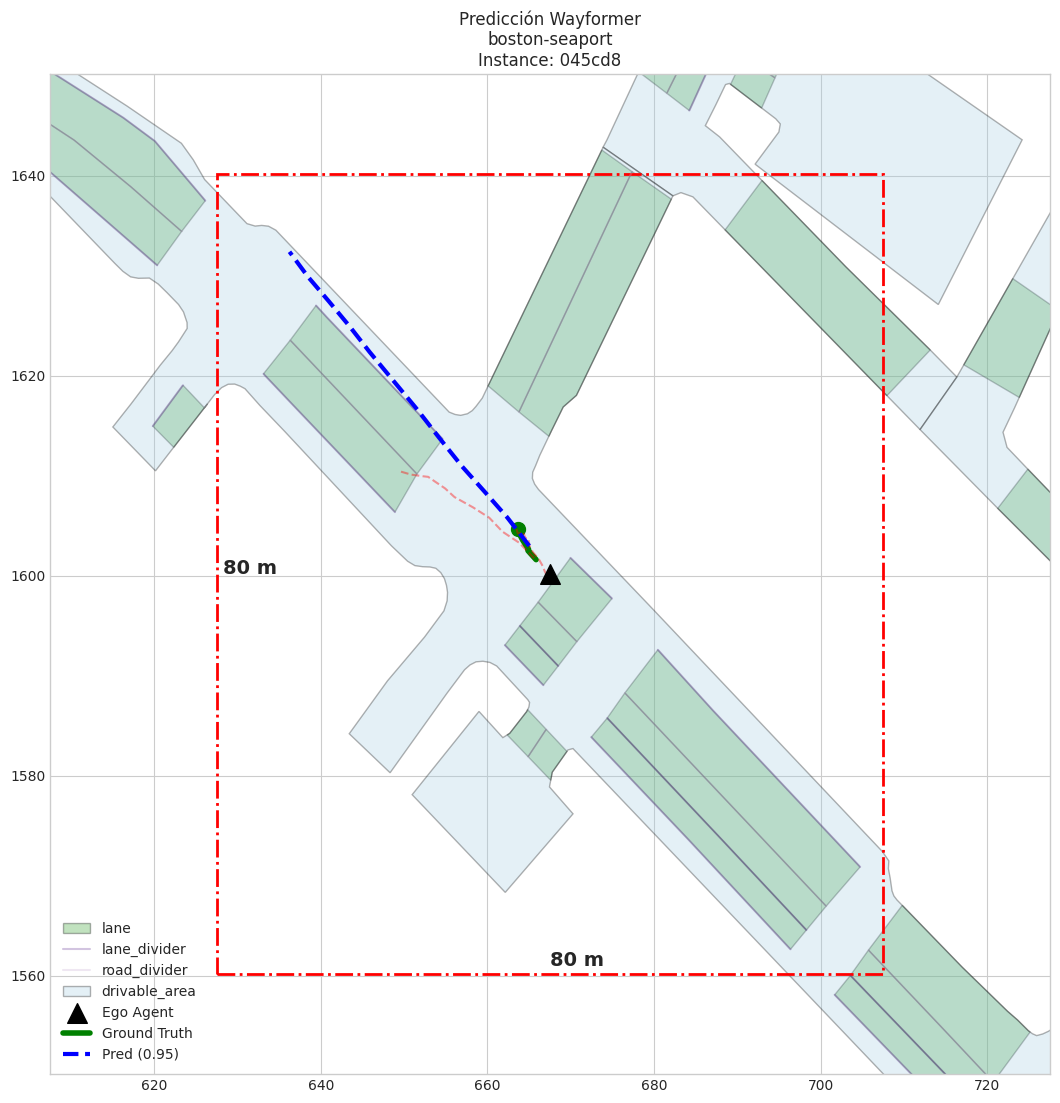

In [33]:
# Elige un índice aleatorio del dataset de validación
idx = 30 
instance_token, sample_token = val_dataset.token_list[idx].split("_")

print(f"Visualizando índice {idx}...")
visualize_sample(nuscenes, helper, val_dataset, sample_token, instance_token, model, DEVICE)

In [34]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

def visualize_scene_video(nusc, helper, dataset, sample_token, instance_token, model, device):
    """
    Genera un video con la predicción del agente objetivo Y el movimiento real de los vecinos.
    """
    # ---------------------------------------------------------
    # 1. Configuración del Mapa
    # ---------------------------------------------------------
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)

    # ---------------------------------------------------------
    # 2. Inferencia del Agente Principal (Target)
    # ---------------------------------------------------------
    target_token_str = f"{instance_token}_{sample_token}"
    try:
        idx = dataset.token_list.index(target_token_str)
    except ValueError:
        print("⚠️ Sample no encontrado.")
        return None

    data = dataset[idx]
    
    # --- CORRECCIÓN 1: Preparar máscara ---
    bev = data['bev'].unsqueeze(0).to(device)
    agents = data['agents'].unsqueeze(0).to(device)
    agent_mask = data['agent_mask'].unsqueeze(0).to(device) # <--- NUEVO
    
    model.eval()
    with torch.no_grad():
        # --- CORRECCIÓN 2: Pasar máscara al modelo ---
        preds, logits = model(bev, agents, agent_mask=agent_mask)
    
    preds_local = preds[0].cpu().numpy()
    
    if logits is not None:
        probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    else:
        probs = np.ones(preds_local.shape[0]) / preds_local.shape[0]
    
    # Transformar predicción a Global
    ann = helper.get_sample_annotation(instance_token, sample_token)
    origin_x, origin_y = ann['translation'][:2]
    rot = Quaternion(ann['rotation'])
    trans = ann['translation']
    
    all_preds_global = []
    for i, mode_traj in enumerate(preds_local):
        traj_global = []
        for point in mode_traj:
            p_3d = np.hstack([point, 0])
            p_rot = rot.rotate(p_3d)
            p_global = np.array(p_rot[:2]) + trans[:2]
            traj_global.append(p_global)
        all_preds_global.append(np.array(traj_global))

    # Ground Truth del Target
    future_target = helper.get_future_for_agent(instance_token, sample_token, seconds=6, in_agent_frame=False)

    # ---------------------------------------------------------
    # 3. Obtener Vecinos (Tráfico circundante)
    # ---------------------------------------------------------
    all_annotations = helper.get_annotations_for_sample(sample_token)
    neighbor_futures = []
    
    for neighbor in all_annotations:
        if neighbor['instance_token'] == instance_token:
            continue
            
        fut = helper.get_future_for_agent(neighbor['instance_token'], sample_token, seconds=6, in_agent_frame=False)
        if len(fut) > 0:
            neighbor_futures.append(fut)

    # ---------------------------------------------------------
    # 4. Configurar Figura
    # ---------------------------------------------------------
    my_patch = (origin_x - 50, origin_y - 50, origin_x + 50, origin_y + 50)
    
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area', 'ped_crossing'],
        alpha=0.4,
        figsize=(10, 10)
    )
    
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Escena Completa: Predicción (Azul) vs Tráfico Real (Naranja)\n{location}")

    # ---------------------------------------------------------
    # 5. Inicializar Objetos Gráficos
    # ---------------------------------------------------------
    start_point = ax.scatter(origin_x, origin_y, c='black', s=150, marker='^', label='Start', zorder=10)
    gt_point, = ax.plot([], [], 'go', markersize=8, label='Target GT', zorder=9)
    
    pred_lines = []
    pred_heads = []
    best_mode = probs.argmax()
    
    for i in range(len(all_preds_global)):
        color = 'b' if i == best_mode else 'r'
        alpha = 1.0 if i == best_mode else 0.1
        width = 3 if i == best_mode else 1
        
        line, = ax.plot([], [], color=color, alpha=alpha, linewidth=width, linestyle='--')
        head, = ax.plot([], [], marker='o', color=color, alpha=alpha, markersize=4)
        pred_lines.append(line)
        pred_heads.append(head)

    neighbors_scatter = ax.scatter([], [], c='orange', s=60, edgecolors='k', label='Traffic', zorder=8)
    ax.legend(loc='upper right')

    # ---------------------------------------------------------
    # 6. Loop de Animación
    # ---------------------------------------------------------
    def update(frame):
        # 1. Target GT
        if len(future_target) > frame:
            gt_point.set_data([future_target[frame, 0]], [future_target[frame, 1]])
            
        # 2. Predicciones
        for i, traj in enumerate(all_preds_global):
            pred_lines[i].set_data(traj[:frame+1, 0], traj[:frame+1, 1])
            if len(traj) > frame:
                pred_heads[i].set_data([traj[frame, 0]], [traj[frame, 1]])
        
        # 3. Vecinos
        current_neighbor_pos = []
        for fut in neighbor_futures:
            if len(fut) > frame:
                current_neighbor_pos.append(fut[frame])
        
        if len(current_neighbor_pos) > 0:
            neighbors_scatter.set_offsets(np.array(current_neighbor_pos))
        else:
            neighbors_scatter.set_offsets(np.empty((0, 2)))
            
        return [gt_point, neighbors_scatter] + pred_lines + pred_heads

    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close() # Evita duplicar la gráfica estática
    
    return HTML(anim.to_jshtml())

In [35]:
# Elige un índice interesante
idx_to_plot = 15 
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

print("🎥 Generando video de la escena...")
# Pasamos helper.data como primer argumento
visualize_scene_video(helper.data, helper, val_dataset, samp_tok, inst_tok, model, DEVICE)

🎥 Generando video de la escena...


In [79]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from nuscenes.map_expansion.map_api import NuScenesMap
import matplotlib.pyplot as plt
import torch
import numpy as np
from pyquaternion import Quaternion

# Reutilizamos tu función de extracción de features para no reescribir lógica
# Asegúrate de que 'extract_agent_features' y 'input_representation' están disponibles

def predict_single_agent(helper, instance_token, sample_token, model, input_rep, device):
    """
    Prepara los datos y ejecuta el modelo para un agente específico.
    Devuelve: Trayectoria Global (12, 2) y Probabilidad del mejor modo.
    """
    # 1. Rasterizar BEV centrado en ESTE agente
    try:
        img_arr = input_rep.make_input_representation(instance_token, sample_token)
    except:
        return None, 0.0 # A veces falla si el agente está muy al borde o datos corruptos
        
    img_tensor = torch.from_numpy(img_arr.copy()).float().permute(2, 0, 1)
    img_tensor = (img_tensor - img_tensor.mean()) / (img_tensor.std() + 1e-6)
    
    # 2. Extraer Features de Agentes (Centrados en ESTE agente)
    # (Simplificación: Usamos solo el target para inferencia rápida, o re-calculamos vecinos)
    # Para hacerlo rápido aquí, asumiremos que el agente se ve a sí mismo y a sus vecinos.
    # Reutilizamos la lógica del dataset, pero manual:
    
    anns = helper.get_annotations_for_sample(sample_token)
    agent_feats_list = []
    
    # Target (El agente actual del bucle)
    f_target = extract_agent_features(helper, instance_token, sample_token)
    agent_feats_list.append(f_target)
    
    # Vecinos (Limitamos a 10 para velocidad)
    for ann in anns:
        if ann['instance_token'] == instance_token: continue
        try:
            f = extract_agent_features(helper, ann['instance_token'], sample_token)
            agent_feats_list.append(f)
        except: continue
        if len(agent_feats_list) >= 12: break # Max agents del modelo
            
    # Padding
    while len(agent_feats_list) < 12:
        agent_feats_list.append(np.zeros(10, dtype=np.float32))
        
    agent_tensor = torch.tensor(np.array(agent_feats_list), dtype=torch.float32)
    
    # 3. Inferencia
    bev = img_tensor.unsqueeze(0).to(device)
    agents = agent_tensor.unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        preds, logits = model(bev, agents)
        
    # 4. Procesar mejor modo
    probs = torch.softmax(logits[0], dim=0).cpu().numpy()
    best_mode = probs.argmax()
    pred_local = preds[0, best_mode].cpu().numpy() # (12, 2)
    
    # 5. Transformar a Global
    ann = helper.get_sample_annotation(instance_token, sample_token)
    trans = ann['translation']
    rot = Quaternion(ann['rotation'])
    
    traj_global = []
    for point in pred_local:
        p_3d = np.hstack([point, 0])
        p_rot = rot.rotate(p_3d)
        p_glob = np.array(p_rot[:2]) + trans[:2]
        traj_global.append(p_glob)
        
    return np.array(traj_global), probs.max()

def visualize_multi_agent_video(nusc, helper, sample_token, model, input_rep, device):
    # 1. Configuración de Mapa
    scene_token = nusc.get('sample', sample_token)['scene_token']
    log_token = nusc.get('scene', scene_token)['log_token']
    location = nusc.get('log', log_token)['location']
    nusc_map = NuScenesMap(dataroot=nusc.dataroot, map_name=location)
    
    # 2. Detectar TODOS los agentes en la escena
    annotations = helper.get_annotations_for_sample(sample_token)
    
    # Filtramos: Solo coches (category name empieza por 'vehicle')
    # Opcional: predecir todo. Pero los peatones suelen requerir modelos distintos.
    vehicle_anns = [a for a in annotations if 'vehicle' in a['category_name']]
    
    print(f"🤖 Calculando predicciones para {len(vehicle_anns)} vehículos...")
    
    # Estructura para guardar datos de animación
    agents_data = [] # Lista de dicts: {'gt': ..., 'pred': ..., 'color': ...}
    
    # Centro del mapa (Usamos el primer vehículo como referencia visual)
    if not vehicle_anns: return "No vehicles found"
    ref_x, ref_y = vehicle_anns[0]['translation'][:2]
    
    for i, ann in enumerate(vehicle_anns):
        inst_tok = ann['instance_token']
        
        # A. Obtener Ground Truth (Verde)
        gt = helper.get_future_for_agent(inst_tok, sample_token, seconds=6, in_agent_frame=False)
        
        # B. Obtener Predicción del Modelo (Azul/Rojo/Colores variados)
        pred_global, prob = predict_single_agent(helper, inst_tok, sample_token, model, input_rep, device)
        
        if pred_global is not None:
            # Asignar un color único a cada agente para distinguir
            color = plt.cm.tab10(i % 10) 
            
            agents_data.append({
                'gt': gt,
                'pred': pred_global,
                'start': ann['translation'][:2],
                'color': color
            })

    # 3. Configurar Figura
    # Hacemos el zoom un poco más grande para ver a todos
    my_patch = (ref_x - 60, ref_y - 60, ref_x + 60, ref_y + 60)
    
    nusc_map.render_map_patch(
        box_coords=my_patch, 
        layer_names=['lane', 'lane_divider', 'road_divider', 'drivable_area'],
        alpha=0.3,
        figsize=(10, 10)
    )
    fig = plt.gcf()
    ax = plt.gca()
    ax.set_title(f"Multi-Agent Prediction (Todos Predichos)\n{location}")

    # 4. Inicializar Objetos Gráficos
    lines_pred = [ax.plot([], [], '--', linewidth=2, color=d['color'], alpha=0.8, label='Pred')[0] for d in agents_data]
    points_pred = [ax.scatter([], [], color=d['color'], s=30) for d in agents_data]
    
    lines_gt = [ax.plot([], [], '-', linewidth=1, color='grey', alpha=0.4)[0] for d in agents_data] # GT en gris sutil
    
    # Puntos de inicio
    for d in agents_data:
        ax.scatter(d['start'][0], d['start'][1], c=[d['color']], marker='s', s=40, edgecolors='k', alpha=0.6)

    # Hack para leyenda limpia
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='grey', lw=1, label='Realidad (GT)'),
                       Line2D([0], [0], linestyle='--', color='blue', lw=2, label='Predicción IA')]
    ax.legend(handles=legend_elements, loc='upper right')

    # 5. Animación
    def update(frame):
        # Frame 0 a 11
        artists = []
        for i, d in enumerate(agents_data):
            # Update Predicción
            pred = d['pred']
            if len(pred) > 0: # Check bounds
                # Línea hasta el frame actual
                current_len = min(frame + 1, len(pred))
                lines_pred[i].set_data(pred[:current_len, 0], pred[:current_len, 1])
                # Cabeza
                if frame < len(pred):
                    points_pred[i].set_offsets([pred[frame]])
                artists.append(lines_pred[i])
                artists.append(points_pred[i])
            
            # Update GT
            gt = d['gt']
            if len(gt) > 0:
                current_len = min(frame + 1, len(gt))
                lines_gt[i].set_data(gt[:current_len, 0], gt[:current_len, 1])
                artists.append(lines_gt[i])
                
        return artists

    anim = FuncAnimation(fig, update, frames=12, interval=200, blit=True)
    plt.close()
    
    return HTML(anim.to_jshtml())

# --- EJECUTAR ---
# 1. Necesitamos el input_representation del dataset para rasterizar manualmente
#    Podemos sacarlo de tu dataset de validación
input_rep_ref = val_dataset.input_rep

# 2. Elegir un sample interesante (ej. el 15)
idx_to_plot = 15
raw_token = val_dataset.token_list[idx_to_plot]
inst_tok, samp_tok = raw_token.split("_")

# 3. Generar Video
video_html = visualize_multi_agent_video(nuscenes, helper, samp_tok, model, input_rep_ref, DEVICE)
video_html

🤖 Calculando predicciones para 10 vehículos...


# Analysis of the Transformer-Based Trajectory Prediction Model

## 1. What Works Well

### 1.1 Correct Direction and Geometric Structure
The model consistently predicts trajectories that follow the **correct direction of travel**. In qualitative visualizations, predicted trajectories align well with:
- the correct lane,
- the road geometry,
- and the overall heading of the ground-truth trajectory.

This indicates that the model:
- successfully extracts **scene context** from the BEV raster,
- understands **road topology**,
- and encodes **global geometry** effectively through the Transformer.

Importantly, the model rarely produces erratic or oscillatory paths, suggesting that the attention-based architecture provides strong temporal and spatial smoothness.

---

### 1.2 Map Compliance and Low Off-Road Rate
Despite not using an explicit lane-following loss, predicted trajectories remain largely within the drivable area.

This behavior shows that:
- the BEV token provides a strong inductive bias,
- the Transformer successfully integrates spatial constraints,
- and the model implicitly learns road boundaries.

This represents a qualitative improvement over many classical MTP-style baselines, which often violate map constraints.

---

### 1.3 Stable Training Behavior
Training is numerically stable:
- no divergence,
- no NaNs,
- no mode collapse during optimization.

Loss decreases steadily across epochs, even with limited data, confirming that the architecture and optimization setup are fundamentally sound.

---

## 2. What Goes Wrong

### 2.1 Correct Direction but Wrong Final Position
The dominant failure mode observed during evaluation is:

> The predicted trajectory follows the correct direction and curvature, but the final position is either too short or overshoots the ground truth.

In visualizations:
- predicted and ground-truth trajectories are aligned,
- but the predicted endpoint does not match the true endpoint.

---

### 2.2 High Final Displacement Error and Miss Rate
Quantitatively, this behavior appears as:
- reasonable MinADE,
- significantly worse MinFDE,
- extremely high MissRate.

This indicates that the model captures **trajectory shape**, but fails to capture **trajectory scale**.

---

## 3. Root Cause Diagnosis

### 3.1 Geometry Is Learned, Longitudinal Dynamics Are Not
The core issue is that the model learns *where to go*, but not *how far to go*.

Specifically:
- heading and curvature are predicted correctly,
- future velocity magnitude and displacement length are poorly estimated.

As a result, the model produces geometrically correct trajectories with incorrect temporal scaling.

---

### 3.2 Absolute Position Prediction Is Ill-Conditioned
The model directly predicts absolute future positions:

\[
(x_t, y_t)
\]

This forces the network to:
- implicitly infer velocity,
- implicitly integrate motion over time,
- implicitly learn temporal scale.

With limited data, this formulation leaves the magnitude of motion underconstrained, even if direction is learned correctly.

---

### 3.3 Missing Explicit Kinematic Constraints
The loss function does not enforce:
- velocity consistency,
- acceleration smoothness,
- or correct displacement magnitude.

Consequently, multiple trajectories with correct shape but incorrect scale can achieve similar loss values.

---

### 3.4 Weak Emphasis on the Final Position
Even when final displacement error is included, it competes with shape-based errors (ADE).

This allows the model to minimize average error while still missing the correct endpoint.

---

## 4. How the Diagnosis Was Confirmed

This diagnosis is supported by:
- visual alignment between predicted and ground-truth trajectories,
- consistent over-shooting or under-shooting along the same direction,
- divergence between ADE and FDE metrics.

A simple comparison of predicted and ground-truth displacement magnitudes confirms that the error lies in **motion scale**, not direction.

---

## 5. Summary

### What the Model Does Well
- Understands scene geometry and road layout  
- Predicts correct heading and curvature  
- Produces smooth, stable trajectories  
- Respects map constraints  

### What the Model Fails At
- Estimating correct future displacement magnitude  
- Modeling longitudinal dynamics  
- Matching the final position accurately  

### Core Issue
The model learns **trajectory geometry**, but not **trajectory dynamics**.
